In [37]:
# Third-party
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
# plt.style.use('notebook.mplstyle')
plt.style.use('apw-notebook')
%matplotlib inline
import corner
import emcee
from scipy.integrate import quad
from scipy.misc import logsumexp
import schwimmbad

In [66]:
tgas = Table.read('../data/tgas.csv')
tgas['hd_id'] = ['240430', '240429']

# Test1: move star 2 at fixed 3d velocity
new_parallax = 4.
tgas[1]['pmra'] = (tgas[1]['pmra']/tgas[1]['parallax']) * new_parallax
tgas[1]['pmdec'] = (tgas[1]['pmdec']/tgas[1]['parallax']) * new_parallax
tgas[1]['parallax'] = new_parallax # make them separated by 150 pc
tgas[1]['parallax_error'] = 0.05

# From John Brewer:
tgas['rv'] = -21.2 # km/s
tgas['rv_error'] = 0.1 # km/s

In [52]:
def get_y_hat(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'ra'], units=None):
    y = np.zeros(len(names))
        
    default_units = dict()
    default_units['ra'] = u.degree
    default_units['dec'] = u.degree
    default_units['parallax'] = u.mas
    default_units['pmra'] = u.mas/u.yr
    default_units['pmdec'] = u.mas/u.yr
    default_units['rv'] = u.km/u.s
    
    if units is None:
        units = [default_units[name] for name in names]
    
    for i,name in enumerate(names):
        y[i] = (row[name]*default_units[name]).to(units[i]).value
    
    return y

In [53]:
def get_cov(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'ra'], units=None):
    
    default_err_units = dict()
    default_err_units['ra'] = u.mas
    default_err_units['dec'] = u.mas
    default_err_units['parallax'] = u.mas
    default_err_units['pmra'] = u.mas/u.yr
    default_err_units['pmdec'] = u.mas/u.yr
    default_err_units['rv'] = u.km/u.s
    
    if units is None:
        units = [default_err_units[name] for name in names]
    
    C = np.zeros((len(names), len(names)))

    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
        C[i,i] = (row[full_name]*default_err_units[name]).to(units[i]).value**2

    for i,name1 in enumerate(names):
        for j,name2 in enumerate(names):
            if j <= i:
                continue
                
            if full_name not in row: # skip if no correlations exist
                continue
                
            full_name = "{}_{}_corr".format(name1, name2)
            u_old = default_err_units[name1]*default_err_units[name2]
            u_new = units[i]*units[j]
            C[i,j] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            C[j,i] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            
    return C

In [54]:
class ProbModel(object):
        
    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars).sum()
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

### Component 1: wide binary

The stars are a wide binary, drawn from the separation distribution 
$$
p(\Delta x) \propto (\Delta x)^{-1} \quad ; \quad 10^{-4}<\Delta x<10~{\rm pc}
$$

### Component 2: co-moving pair

The stars are co-moving but not necessarily *bound*

### Component 3: chance alignment

The stars are individually drawn from the field population

---

In [55]:
def ln_p_lndx(lndx, lnmin=np.log(1E-4), lnmax=np.log(1E1)): # units are pc
    if lndx < lnmin or lndx > lnmax:
        return -np.inf
    return -np.log(lnmax-lnmin)

res,_ = quad(lambda x: np.exp(ln_p_lndx(x)), np.log(1E-4), np.log(1E1))
assert np.allclose(res, 1.)

In [56]:
kmspc_to_masyr = 210.94953
masyr_to_kmspc = 1/kmspc_to_masyr

In [57]:
class MixtureModel(ProbModel):
    
    def __init__(self, tgas_rows, mass=2.*u.Msun, sigma_v=25.*u.km/u.s):
        """
        TODO: the right thing to do is to rotate (vra,vdec,vr) to (vx,vy,vz), but
            this is ok at the ~10 m/s level (given their small sky separation)
        """ 
        assert len(tgas_rows) == 2
        
        self.y_hats = []
        self.Covs = []
        self.Cinvs = []
        self._uvecs = []
        self._logdets = []
        
        for row in tgas_rows:
            y_hat = get_y_hat(row, names=['parallax', 'pmra', 'pmdec', 'rv'])
            Cov = get_cov(row, names=['parallax', 'pmra', 'pmdec', 'rv'])
            _,log_det = np.linalg.slogdet(2*np.pi*Cov)
            
            rep = coord.UnitSphericalRepresentation(lon=row['ra']*u.deg, 
                                                    lat=row['dec']*u.deg)
            uvec = rep.represent_as(coord.CartesianRepresentation).xyz.value
            
            
            self.y_hats.append(y_hat)
            self.Covs.append(Cov)
            self.Cinvs.append(np.linalg.inv(Cov))
            self._uvecs.append(uvec)
            self._logdets.append(log_det)
        
        # sky separation
        coords = coord.SkyCoord(ra=tgas_rows['ra']*u.deg, 
                                dec=tgas_rows['dec']*u.deg)
        self._cos_sep = np.cos(coords[1].separation(coords[0]))
                
        # some assumed parameters
        self._G = G.to(u.pc/u.Msun*u.km**2/u.s**2).value
        self.mass = mass.to(u.Msun).value # we assume it is an equal-mass pair
        self.sigma_v = sigma_v.to(u.km/u.s).value
    
    def unpack_pars1(self, pars):
        r1, vra1, vdec1, vr1, *_, ln_sep, f1, f2 = pars
        
        sep = np.exp(ln_sep)
        
        y1 = np.array([1000./r1, # mas
                       vra1 / r1 * kmspc_to_masyr, # mas/yr
                       vdec1 / r1 * kmspc_to_masyr, # mas/yr 
                       vr1]) # km/s
        
        # Do some trig to compute true r2 given sky positions, r1, a.
        # For generic separations, a, the solution has two roots: one where star 1 is 
        # closer and one where star 2 is closer.
        r2 = r1 * np.array([self._cos_sep + np.sqrt(self._cos_sep + (sep/r1)**2 - 1.),
                            self._cos_sep - np.sqrt(self._cos_sep + (sep/r1)**2 - 1.)]) # two roots
        
        # The magnitude of the velocity difference is set by the separation 
        # and an assumed mass -- we convert to semi-major axis assuming a 
        # circular orbit and equal mass pair:
        a = sep / 2 
        dv_mag = 2*np.sqrt(self._G * self.mass / sep) # km/s
        
        # Assuming the pair are a bound 2-body system on a circular orbit, the 
        # difference in 3-space velocity vectors should be perpendicular to the 
        # separation vector, x2-x1. But we don't know if r1>r2 or r2>r1, and we
        # don't know if they are orbiting clockwise or counter-clockwise (on the 
        # sky), so we consider all 4 scenarios.
        x1 = r1 * self._uvecs[0]
        x2 = r2[:,None] * self._uvecs[1][None] # (2, 3)
        dx = x2 - x1
        dv = np.cross(dx, x2)
        dv = dv_mag * dv / np.linalg.norm(dv, axis=-1)[:,None] # has shape (2, 3)
        
        # clockwise vs. counter-clockwise
        v1 = np.array([vra1, vdec1, vr1])
        v2 = np.zeros((2,2,3))
        v2[:,0] = v1 + dv
        v2[:,1] = v1 - dv
        
        y2 = np.zeros((2,2,4))
        y2[0,:,0] = 1000. / r2[0] # mas
        y2[1,:,0] = 1000. / r2[1] # mas
        y2[:,:,1:3] = v2[...,:2] / r2[:,None] * kmspc_to_masyr # mas/yr
        y2[:,:,3] = v2[...,2] # km/s

        return y1, y2.reshape(-1, 4) # flatten so it's (nscenarios, ndim)
    
    def ln_likelihood1(self, pars):
        """
        Compute the log-likelihood for component 1 of the mixture model:
        wide binary
        """
        
        y1,y2 = self.unpack_pars1(pars)
        
        dy1 = (y1 - self.y_hats[0])
        ln_p1 = -0.5 * self._logdets[0] - 0.5 * (dy1.T @ self.Cinvs[0] @ dy1)
        
        ln_p2 = np.zeros(4)
        for i in range(4): # 4 scenarios (r1 > r2 vs. r2 > r1) x (+∆v vs. -∆v)
            dy2 = (y2[i] - self.y_hats[0])
            ln_p2[i] = -0.5 * self._logdets[1] - 0.5 * dy2.T @ self.Cinvs[1] @ dy2
        return ln_p1 + logsumexp(ln_p2)
    
    def unpack_pars2(self, pars):
        r1, vra1, vdec1, vr1, r2, vra2, vdec2, vr2, *_ = pars
        
        y1 = np.array([1000./r1, # mas
                       vra1 / r1 * kmspc_to_masyr, # mas/yr
                       vdec1 / r1 * kmspc_to_masyr, # mas/yr 
                       vr1]) # km/s
        
        y2 = np.array([1000./r2, # mas
                       y1[1],
                       y1[2],
                       y1[3]])
        
        return y1, y2
        
    def ln_likelihood2(self, pars):
        """
        Compute the log-likelihood for component 2 of the mixture model:
        unbound but comoving
        """
        ys = self.unpack_pars2(pars)
        
        ln_p = 0
        for i in range(2): # only ever 2 stars allowed
            dy = (ys[i] - self.y_hats[i])
            ln_p += -0.5 * self._logdets[i] - 0.5 * (dy.T @ self.Cinvs[i] @ dy)
        
        return ln_p
    
    def unpack_pars3(self, pars):
        r1, vra1, vdec1, vr1, r2, vra2, vdec2, vr2, *_ = pars
        
        y1 = np.array([1000./r1, # mas
                       vra1 / r1 * kmspc_to_masyr, # mas/yr
                       vdec1 / r1 * kmspc_to_masyr, # mas/yr 
                       vr1]) # km/s
        
        y2 = np.array([1000./r2, # mas
                       vra2 / r2 * kmspc_to_masyr, # mas/yr
                       vdec2 / r2 * kmspc_to_masyr, # mas/yr 
                       vr2]) # km/s
        
        return y1, y2
    
    def ln_likelihood3(self, pars):
        """
        Compute the log-likelihood for component 3 of the mixture model:
        two independent draws from the field population
        """
        ys = self.unpack_pars3(pars)
        
        ln_p = 0
        for i in range(2): # only ever 2 stars allowed
            dy = (ys[i] - self.y_hats[i])
            ln_p += -0.5 * self._logdets[i] - 0.5 * (dy.T @ self.Cinvs[i] @ dy)
        
        return ln_p
        
    def ln_likelihood(self, pars):
        *_, f1, f2 = pars
        
        f3 = 1 - (f1+f2)
        
        lnL1 = self.ln_likelihood1(pars)
        lnL2 = self.ln_likelihood2(pars)
        lnL3 = self.ln_likelihood3(pars)
        
        return logsumexp([lnL1, lnL2, lnL3], b=[f1, f2, f3])

    def ln_prior(self, pars):
        r1, vra1, vdec1, vr1, r2, vra2, vdec2, vr2, ln_sep, f1, f2 = pars
        
        lp = 0.
        
        # uniform prior on weights
        if f1 < 0 or f1 > 1. or f2 < 0 or f2 > 1 or (f1+f2) > 1:
            return -np.inf
        
        # Gaussian prior on velocities of the stars
        v = np.array([vra1, vdec1, vr1])
        lp += -0.5 * np.sum(v**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        v = np.array([vra2, vdec2, vr2])
        lp += -0.5 * np.sum(v**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        # Prior on separations: uniform in ln(separation)
        lp += ln_p_lndx(ln_sep)
        
        # Uniform space density prior on distance to stars, indepedently
        r_lim = 300. # pc
        if r1 > r_lim or r2 > r_lim:
            return -np.inf
        lp += np.log(3/r_lim**3) + 2*np.log(r1)
        lp += np.log(3/r_lim**3) + 2*np.log(r2)
        
        return lp
    
    def get_p0(self):
        p0 = []
        for yh in self.y_hats:
            p0 += [1000./yh[0], 4.74047*yh[1]/yh[0], 4.74047*yh[2]/yh[0], yh[3]]
        
        p0.append(np.log(0.6)) # log(separation)
        p0 += [0.4, 0.4] # weights for first two mixture components
        
        return np.array(p0)

In [58]:
model = MixtureModel(tgas, mass=2.07*u.Msun, sigma_v=25*u.km/u.s)

In [59]:
p0 = model.get_p0()
ndim = len(p0)
model.ln_likelihood(p0), model.ln_prior(p0)

(1.6251065523730204, -43.253372528723773)

Standard ensemble sampler:

In [60]:
nwalkers = 256

In [61]:
%%time

all_p0 = np.random.normal(p0, 1E-3*np.abs(p0), size=(nwalkers, ndim))
ndim = len(p0)
with schwimmbad.MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model, pool=pool)

    pos,_,_ = sampler.run_mcmc(all_p0, N=1024)
    sampler.reset()
    pos,_,_ = sampler.run_mcmc(pos, N=4096)

/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:199: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:199: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:199: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:199: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value enco

CPU times: user 49.7 s, sys: 3.28 s, total: 53 s
Wall time: 5min 40s


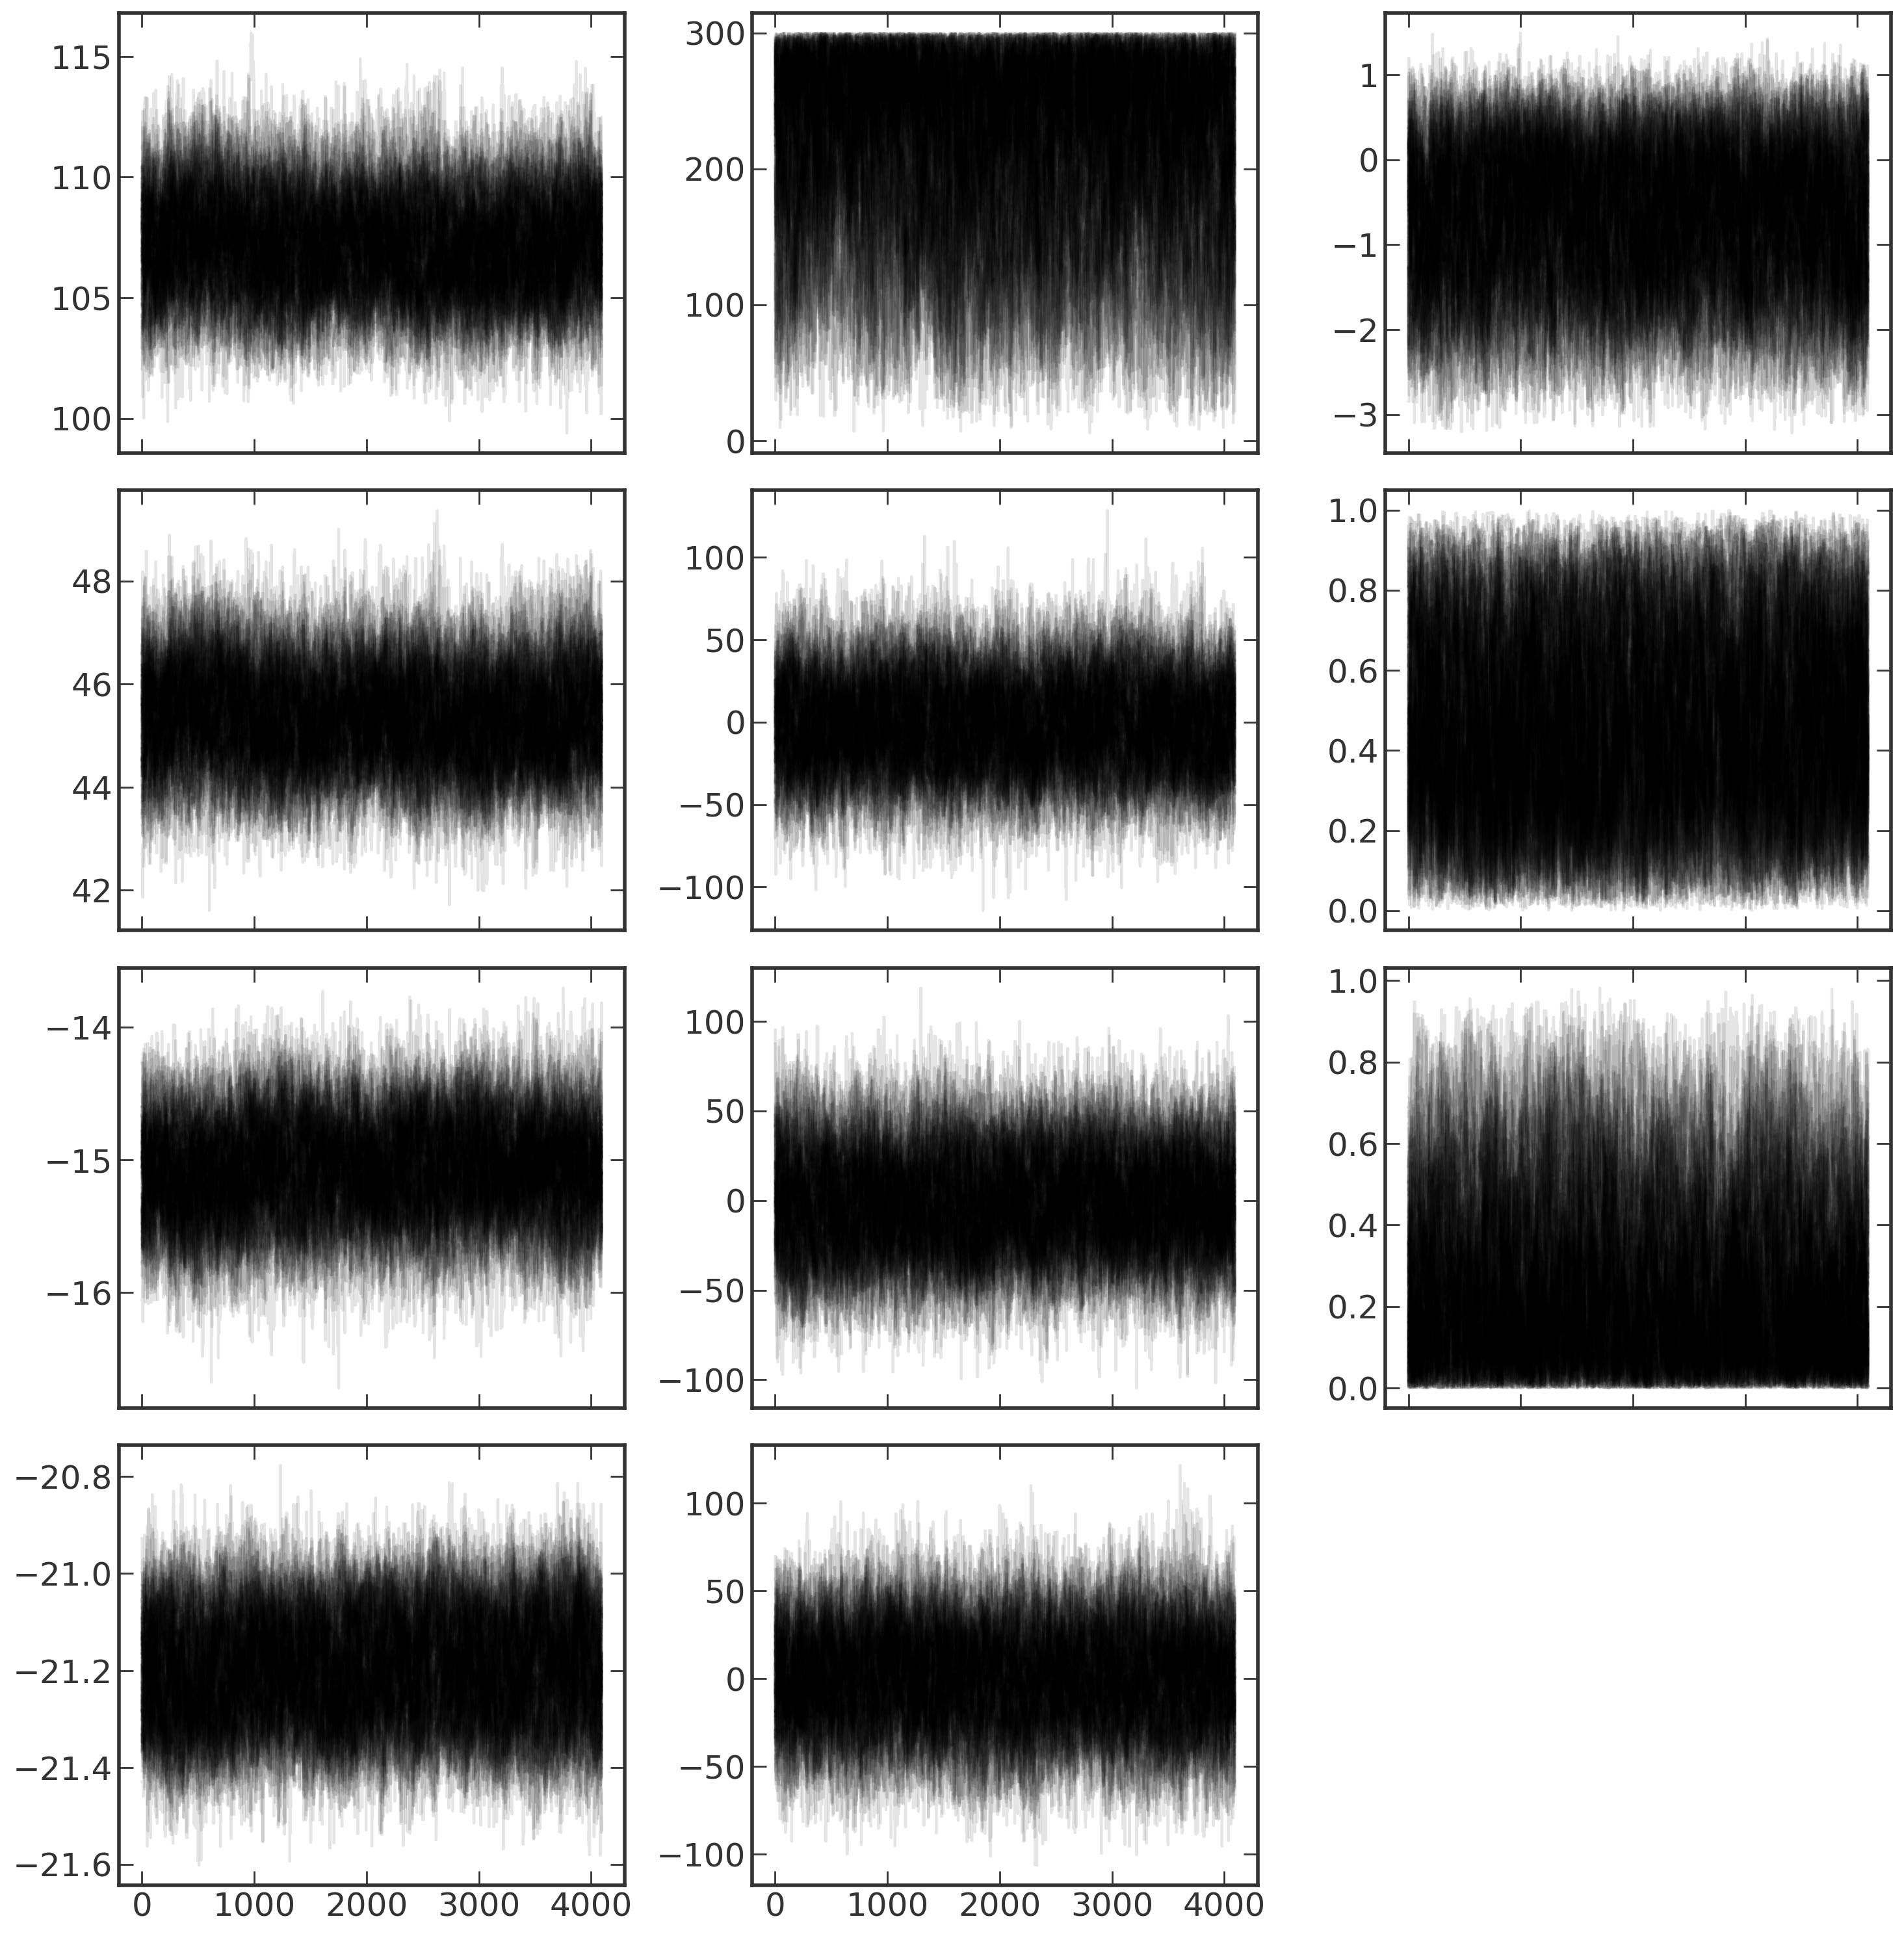

In [62]:
n_plot_walkers = 128
alpha = 0.1

fig,axes = plt.subplots(4, 3, figsize=(15,15), sharex=True)

for k in range(0,4):
    for j in range(n_plot_walkers):
        axes[k,0].plot(sampler.chain[j,:,k], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')
        
for k in range(0,4):
    for j in range(n_plot_walkers):
        axes[k,1].plot(sampler.chain[j,:,k+4], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')
        
for k in range(0,3):
    for j in range(n_plot_walkers):
        axes[k,2].plot(sampler.chain[j,:,k+8], marker='', alpha=alpha, 
                       drawstyle='steps-mid', color='k')

fig.tight_layout()

axes[-1,-1].set_visible(False)

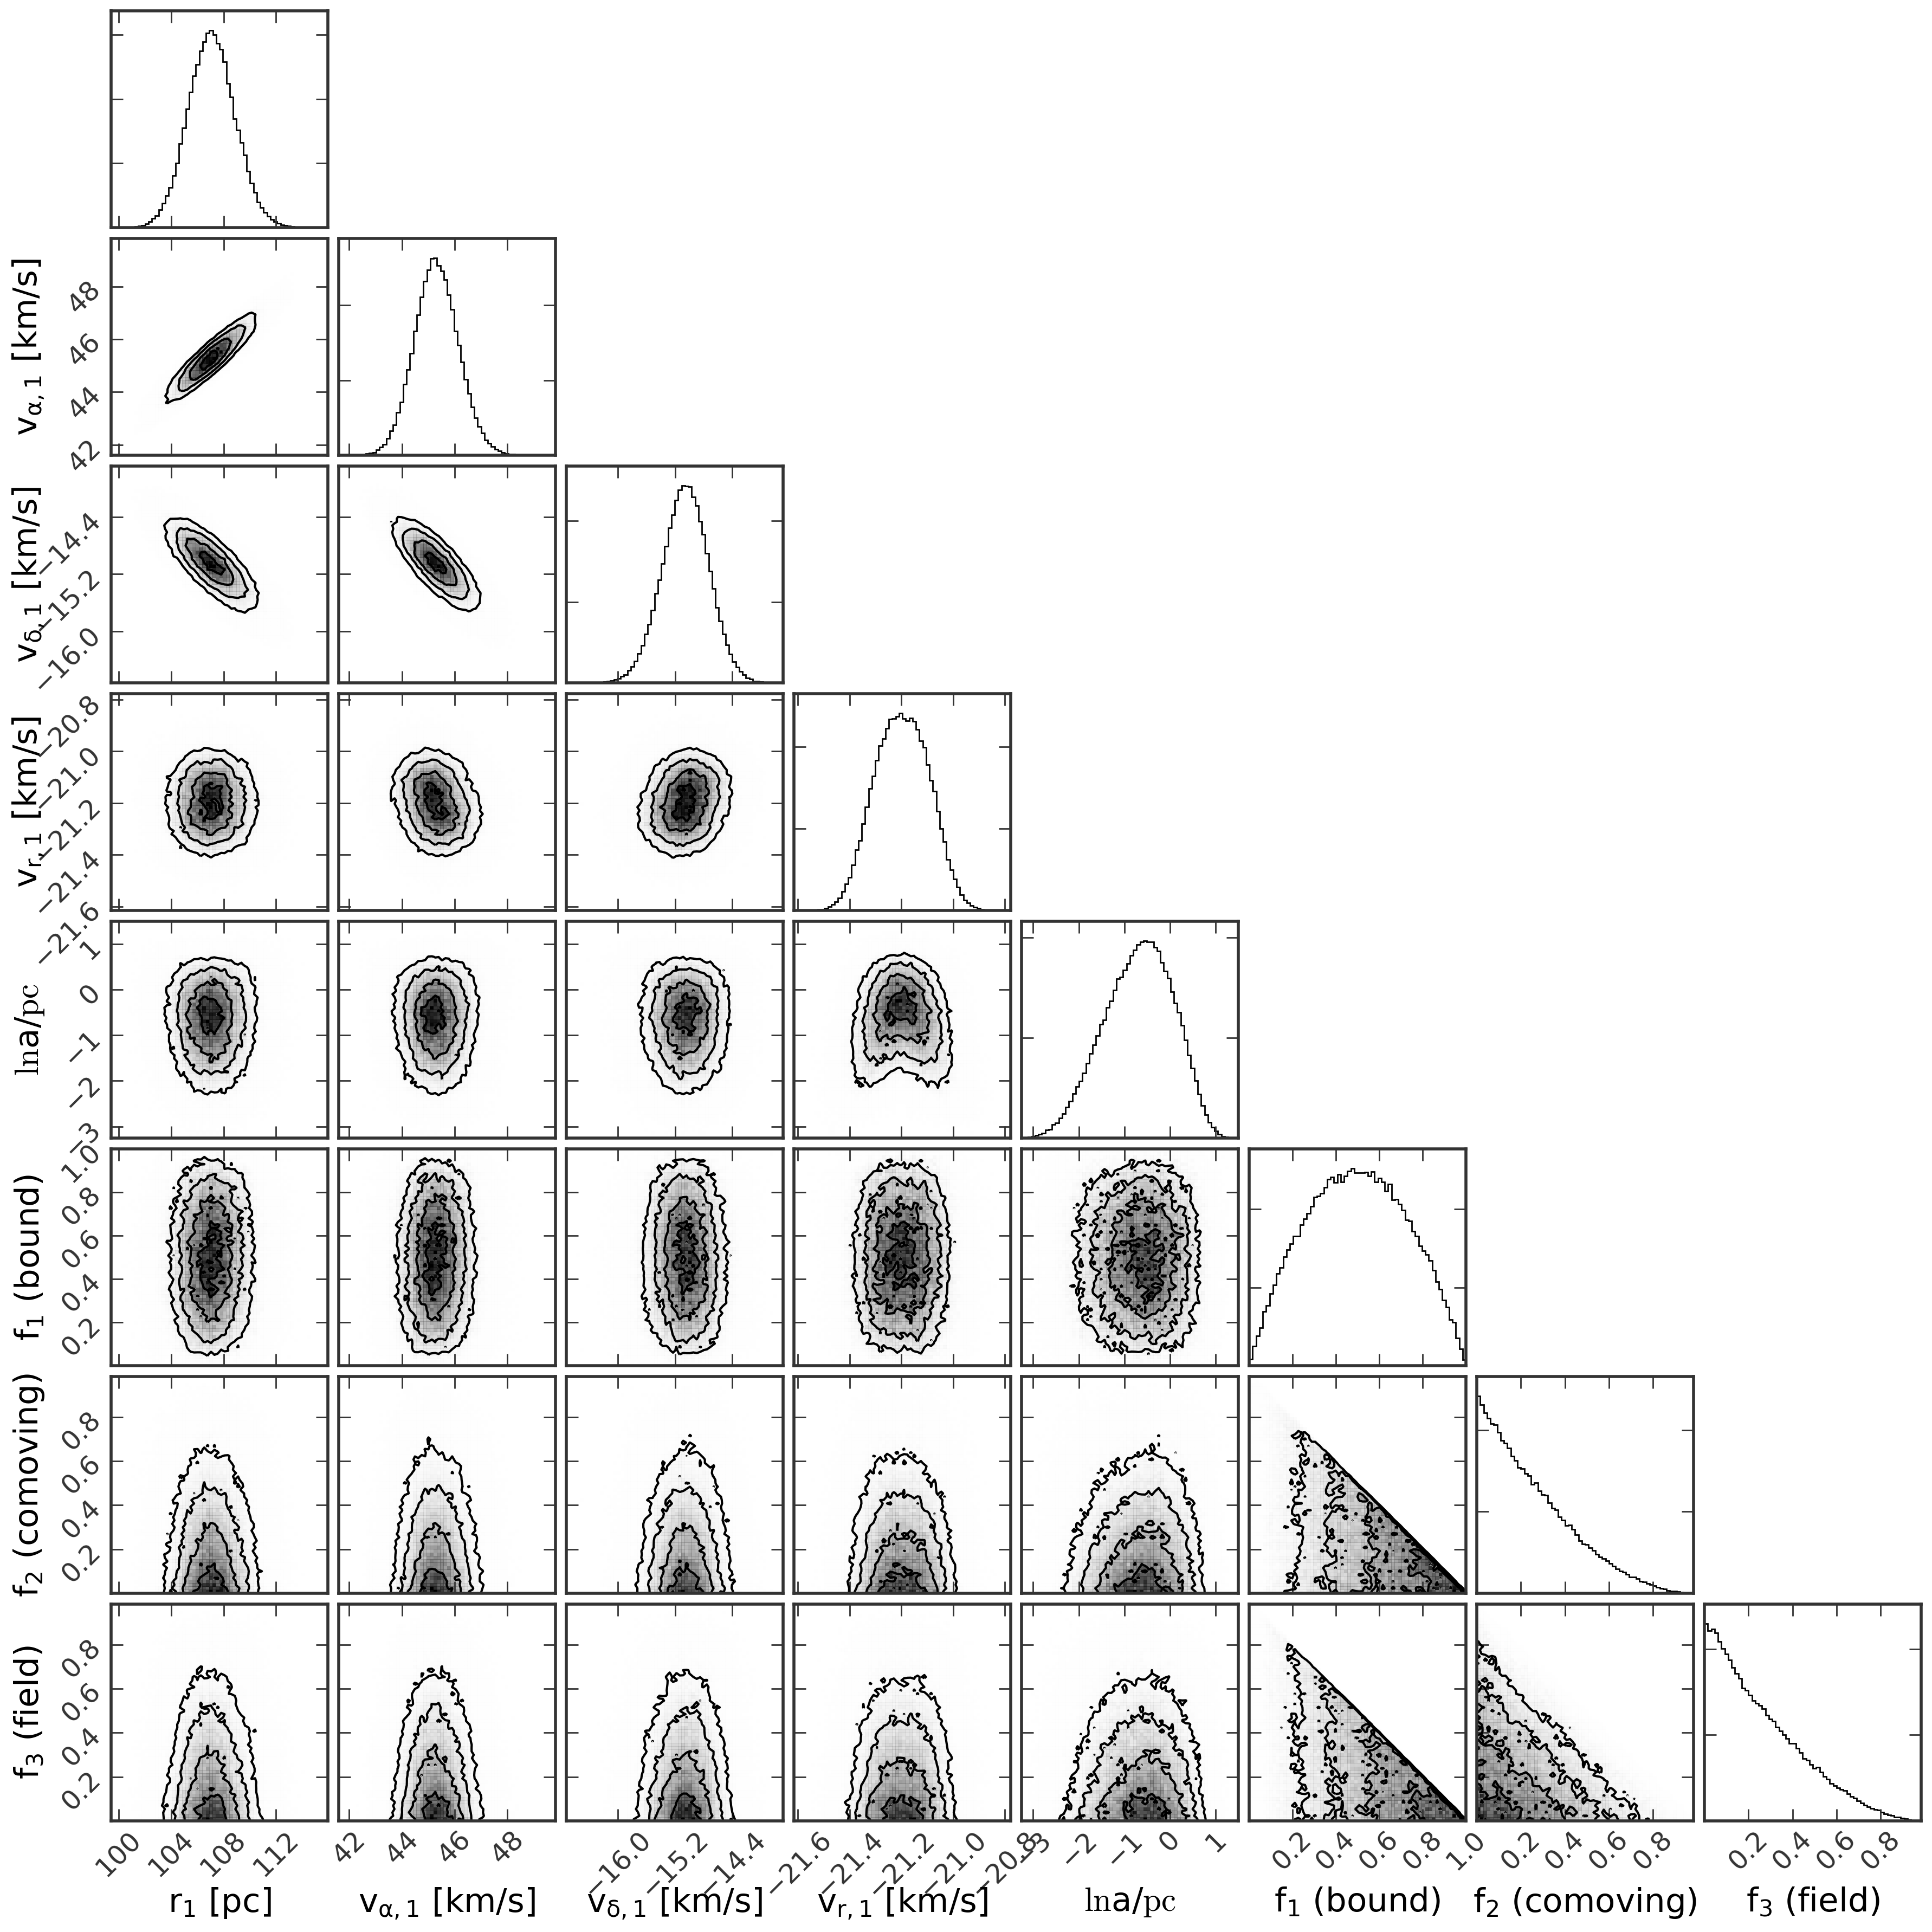

In [63]:
flatchain = sampler.flatchain[:,[0,1,2,3,8,9,10]]
flatchain = np.vstack((flatchain.T, 1-(flatchain[:,5]+flatchain[:,6]))).T

fig = corner.corner(flatchain, bins=64, plot_datapoints=False,
                    labels=['$r_1$ [pc]', r'$v_{\alpha,1}$ [km/s]', r'$v_{\delta,1}$ [km/s]', '$v_{r,1}$ [km/s]', 
                            r'$\ln a/{\rm pc}$', '$f_1$ (bound)', '$f_2$ (comoving)', '$f_3$ (field)'])
fig.savefig('../plots/mixture_model_3component_testa.png', dpi=256)
del fig

In [20]:
# ntemps = 16
# betas = np.logspace(0, -8, ntemps)
# nwalkers = 128

In [21]:
# %%time

# all_p0 = np.random.normal(p0, 1E-3*np.abs(p0), size=(ntemps, nwalkers, ndim))
# ndim = len(p0)
# with schwimmbad.MultiPool() as pool:
#     sampler = emcee.PTSampler(ntemps, nwalkers, ndim, 
#                               model.ln_likelihood, model.ln_prior,
#                               betas=betas, pool=pool)

#     sampler.reset()
#     pos,_,_ = sampler.run_mcmc(all_p0, N=128)
#     sampler.reset()
#     pos,_,_ = sampler.run_mcmc(pos, N=1024)

In [79]:
# for k in range(ndim):
#     plt.figure()
    
#     i = 0 # zero temperature?    
#     for j in range(nwalkers):
#         plt.plot(sampler.chain[i,j,:,k], marker='', alpha=0.2, 
#                  drawstyle='steps-mid', color='k')

In [1]:
_ = corner.corner(sampler.flatchain, bins=64)
#                   labels=['$r_1$', r'$v_{\alpha,1}$', r'$v_{\delta,1}$', '$v_{r,1}$', r'$\ln a$ [pc]'])

NameError: name 'corner' is not defined